#Project 2
Instructions: 
- Please read the project description before your start.
- To save a copy of your ipython notebook: click ```File -> Download .ipyhon```
- Write your code in the code cells below each Step description. You may add extra cells if needed.


In [ ]:

pip install statsmodels==0.12.0
import statsmodels

     |████████████████████████████████| 9.5MB 1.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

pip install arch
from arch import arch_model

     |████████████████████████████████| 808kB 8.7MB/s 


## Modeling volatility using US Dollar / Australian Dollar exchange rate data
Step 1: import data from Github
- Check to see that DataFrame usdaud a column ```USDAUD```, which is the USD/AUD exchange rate
- The sample is daily and covers the period from Jan 2, 2001 to Oct 14, 2004

In [ ]:
# usdaud = pd.read_csv('https://raw.githubusercontent.com/shihanxie/Econ475/main/data/usdaud.csv', 
#                       na_values = '.', dtype={'USDYEN': np.float})
# usdaud.index = pd.to_datetime(usdaud.index)
usdaud.index = pd.date_range(start='2001-01-02', periods= usdaud.shape[0], freq='D')
usdaud.head(-1)

,USDAUD
2001-01-02,0.5592
2001-01-03,0.5635
2001-01-04,0.5655
2001-01-05,0.5712
2001-01-06,0.5660
...,...
2004-10-09,0.7315
2004-10-10,0.7301
2004-10-11,0.7340
2004-10-12,0.7284


Step 2: Compute and plot the first difference of the log(exchange rate), or $\Delta \log(usdaud_t) \times 100$. From now on, we will use $y_t$ to refer $\Delta \log(usdaud_t) \times 100$, which is the daily percentage change in USD/AUD exchange rate.

Hint: use ```np.log(var).diff()``` to compute the first difference of the log of ```var```.

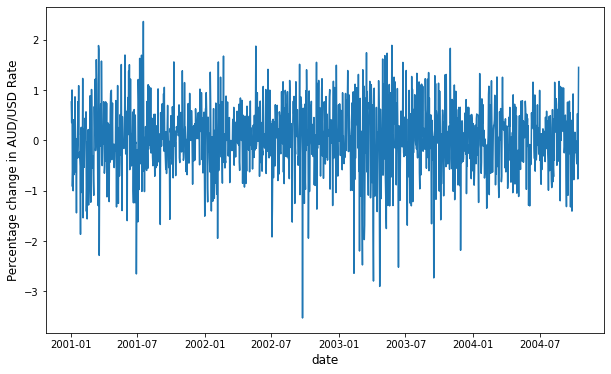

In [ ]:
usdaud['y_t'] = np.log(usdaud['USDAUD']).diff() * 100

plt.figure(figsize=(10,6))
plt.plot(usdaud['y_t'])
ax = plt.gca()
ax.set_ylabel('Percentage change in AUD/USD Rate', fontsize = 'large')
ax.set_xlabel('date', fontsize = 'large')
plt.show()


Step 3: Plot the histogram and compute the descriptive statistics of $y_t$. Conduct the proper test to see if it is normally distributed.

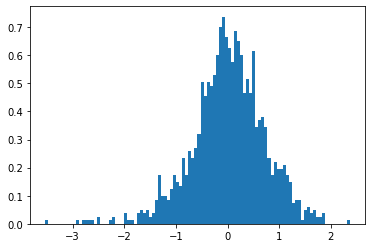

count    1381.000000
mean        0.020510
std         0.699923
min        -3.529074
25%        -0.377257
50%         0.036623
75%         0.463301
max         2.364642
Name: y_t, dtype: float64
Skewness:  -0.43650388305589627
Kurtosis:  1.380425650258319
Jarque-Bera test statistic is:  151.93178356846568
Jarque-Bera test p-value is:  0.0


In [ ]:
_, bins, _ = plt.hist(usdaud['y_t'],density = 1, bins=100)
plt.show()
print(usdaud['y_t'].describe())
print('Skewness: ', usdaud['y_t'].skew())
print('Kurtosis: ', usdaud['y_t'].kurt())
print('Jarque-Bera test statistic is: ', stats.jarque_bera(usdaud['y_t'].dropna())[0])
print('Jarque-Bera test p-value is: ', stats.jarque_bera(usdaud['y_t'].dropna())[1])

Step 4: Compare the historgram of $y_t$ to a normal distribution.

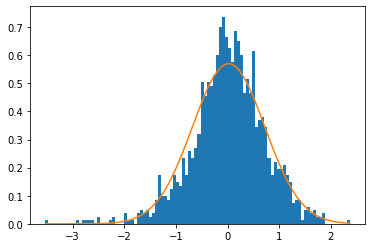

In [ ]:
mu, sigma = stats.norm.fit(usdaud['y_t'].dropna())
best_fit_line = stats.norm.pdf(bins, mu, sigma)
plt.hist(usdaud['y_t'],density = 1, bins=100)
plt.plot(bins, best_fit_line)
plt.show()

Step 5: Compute the correlogram of squared $y_t$ up to 12 lags.

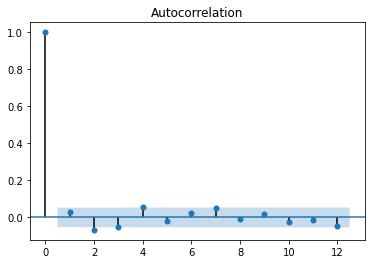

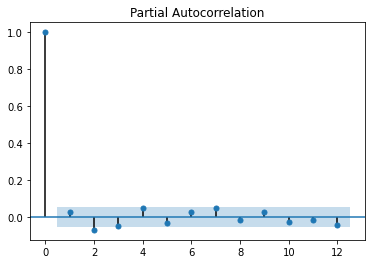

In [ ]:
usdaud['y_t_squared'] = usdaud['y_t'] ** 2

plot_acf(usdaud['y_t'].dropna(), lags = 12)
plot_pacf(usdaud['y_t'].dropna(), lags = 12)
plt.show()

Step 6: Estimate an AR(1) model for squared $y_t$

In [ ]:
result_ar1 = ARIMA(usdaud['y_t_squared'], order=(1,0,0)).fit()
print(result_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:            y_t_squared   No. Observations:                 1382
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1799.980
Date:                Sat, 01 May 2021   AIC                           3605.960
Time:                        02:39:09   BIC                           3621.653
Sample:                    01-02-2001   HQIC                          3611.830
                         - 10-14-2004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4900      0.040     12.144      0.000       0.411       0.569
ar.L1          0.0592      0.020      3.012      0.003       0.021       0.098
sigma2         0.7936      0.010     78.557      0.0

Step 7: Estimate an ARCH(1) model and a GARCH(1,1) model for
$$
\begin{aligned}
&y_t =\mu+\varepsilon_{t} \\
&\varepsilon_{t} \mid \Omega_{t-1} \sim N\left(0, \sigma_{t}^{2}\right)
\end{aligned}
$$

In [ ]:
result_arch1 = arch_model(usdaud['y_t'].dropna(), vol='Garch', p=1, q=0, dist='Normal').fit()
result_garch1_1 = arch_model(usdaud['y_t'].dropna(), vol='Garch', p=1, q=1, dist='Normal').fit()

print(result_arch1.summary())
print(result_garch1_1.summary())


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1570.1329745973953
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1566.3842348837911
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1477.3073254004657
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1466.8095971020887
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1465.257708264372
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1463.111821838681
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1462.8254905106833
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1462.8172947343844
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1462.8169311014042
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1462.8168780592673
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1462.8168780593169
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1433.37

Step 8: Estimate an AR(1)-ARCH(1) model and an AR(1)-GARCH(1,1) model for
$$
\begin{aligned}
&y_t =\mu+\rho y_{t-1} + \varepsilon_{t} \\
&\varepsilon_{t} \mid \Omega_{t-1} \sim N\left(0, \sigma_{t}^{2}\right)
\end{aligned}
$$

In [ ]:
#ar and garch
result_ar_arch = arch_model(usdaud['y_t'].dropna(), mean='AR', lags = 1, vol='Garch', p=1, q=0, dist='Normal').fit()
result_ar_garch = arch_model(usdaud['y_t'].dropna(), mean='AR', lags = 1, vol='Garch', p=1, q=1, dist='Normal').fit()
print(result_ar_arch.summary())
print(result_ar_garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1568.0973477675218
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1564.3689395548224
Iteration:      3,   Func. Count:     26,   Neg. LLF: 1528.3067410319074
Iteration:      4,   Func. Count:     35,   Neg. LLF: 1477.5509476053664
Iteration:      5,   Func. Count:     41,   Neg. LLF: 1467.9667321564307
Iteration:      6,   Func. Count:     48,   Neg. LLF: 1466.8792512208754
Iteration:      7,   Func. Count:     56,   Neg. LLF: 1461.556466859029
Iteration:      8,   Func. Count:     62,   Neg. LLF: 1461.333253366922
Iteration:      9,   Func. Count:     68,   Neg. LLF: 1461.2591939857666
Iteration:     10,   Func. Count:     74,   Neg. LLF: 1461.2570731532278
Iteration:     11,   Func. Count:     80,   Neg. LLF: 1461.2569598646874
Iteration:     12,   Func. Count:     86,   Neg. LLF: 1461.2569567960886
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1461.2569567960204
            Iter

Step 9: Plot the estimated conditional variance of the best-fitting model among the ones considered

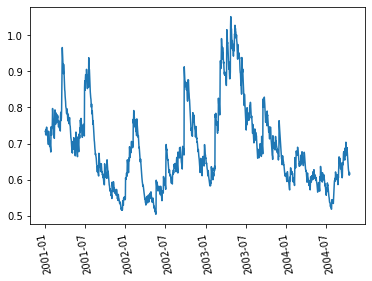

In [ ]:
# GARCHMODEL (1,1) best fit to the data

plt.plot(result_garch1_1.conditional_volatility)
ax = plt.gca()
ax.tick_params(axis = 'x', rotation = 100)
plt.show()